# Challenge
Throughout this module, we introduced the amazing and yet challenging domain of unsupervised learning by covering some of the most popular clustering and dimensionality reduction algorithms. Now, it's time for you to apply your unsupervised learning knowledge. In this challenge, you'll work with a dataset of your choice. As always, Kaggle is one of your best friends. You can spend some time on Kaggle and pick a beautiful dataset. Using this dataset:

 - Apply dimensionality reduction techniques to visualize the observations.
 - Apply clustering techniques to group together similar observations.
 
In each of the tasks above, try alternative methods and select a best performing one. Discuss how dimensionality reduction and clustering algorithms enable you to gain insights regarding the data.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import umap
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics
from sqlalchemy import create_engine
import openml
from sklearn.datasets import fetch_openml
import warnings

warnings.filterwarnings('ignore')

## Choose a Dataset and Load

In [2]:
openml_df = openml.datasets.list_datasets(output_format='dataframe')
openml_df = openml_df[[
    'did', 'name', 'NumberOfInstances',
    'NumberOfFeatures', 'NumberOfClasses']]

openml_df.head(10)

,did,name,NumberOfInstances,NumberOfFeatures,NumberOfClasses
2,2,anneal,898.0,39.0,5.0
3,3,kr-vs-kp,3196.0,37.0,2.0
4,4,labor,57.0,17.0,2.0
5,5,arrhythmia,452.0,280.0,13.0
6,6,letter,20000.0,17.0,26.0
7,7,audiology,226.0,70.0,24.0
8,8,liver-disorders,345.0,6.0,0.0
9,9,autos,205.0,26.0,6.0
10,10,lymph,148.0,19.0,4.0
11,11,balance-scale,625.0,5.0,3.0


In [3]:
#Sort possible datasets into optimal parameter values
openml_df = openml_df[openml_df.NumberOfInstances < 100000]
openml_df = openml_df[openml_df.NumberOfFeatures > 50]
openml_df = openml _df[openml_df.NumberOfClasses >= 2].sort_values(['NumberOfInstances'], ascending=False)

openml_df.head(50)

,did,name,NumberOfInstances,NumberOfFeatures,NumberOfClasses
41081,41081,SVHN,99289.0,3073.0,10.0
1242,1242,vehicleNorm,98528.0,101.0,2.0
357,357,vehicle_sensIT,98528.0,101.0,2.0
40923,40923,Devnagari-Script,92000.0,1025.0,46.0
41168,41168,jannis,83733.0,55.0,4.0
41138,41138,APSFailure,76000.0,171.0,2.0
41982,41982,Kuzushiji-MNIST,70000.0,785.0,10.0
554,554,mnist_784,70000.0,785.0,10.0
40996,40996,Fashion-MNIST,70000.0,785.0,10.0
40927,40927,CIFAR_10,60000.0,3073.0,10.0


## Dataset Selection: Credit Card Fraud Detection
I ended up deciding to go with a dataset that contained 30 features, and two classes (fraudulent vs. not fraudulent). This [dataset](https://www.openml.org/d/42175) was extracted from the openml library. 28 of the 30 features are principal components derived by running PCA on the original dataset, which was done to obscure the original data for confidentiality reasons. The final two features were Amount (dollar amount of the credit card charge) and Time (the data collection took place over two days, and this feature represents how many seconds had passed since the first recorded transaction). I removed the Time feature because I couldn't see any way it might help with clustering or classification. 

In [190]:
dataset = openml.datasets.get_dataset('CreditCardFraudDetection')    #credit card fraud

X, y, categorical_indicator, attribute_names = dataset.get_data(
    target=dataset.default_target_attribute,
    dataset_format='dataframe'
)

print(X.info())
X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [191]:
X = X.drop('Time', axis=1)

In [192]:
X.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [193]:
unique_y = list(np.unique(y))
y = np.array([unique_y.index(i) for i in list(y)])

In [194]:
print(X.shape, y.shape)

(284807, 29) (284807,)


## Explore the Dataset

In [195]:
y = pd.DataFrame(y, columns=['Class'])

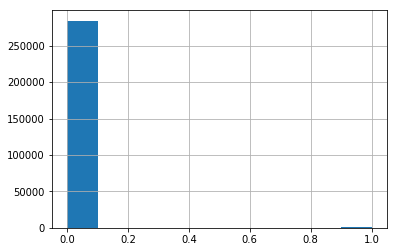

In [196]:
y['Class'].hist()

## Undersampling to Solve Class Imbalance
As you can see in the previous histogram, of the 280,000+ transactions in this dataset, less than 1% were classified as "fraudulent." This class imbalance could lead to significant issues with later clustering attempts. To address this, I undersampled the majority "non-fraudulent" class so that the final dataset contained all of the original "fraudulent" transactions and an equal number of "non-fraudulent" transactions.

In [197]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

In [198]:
headers = X.columns
X_new = pd.DataFrame(columns = headers)

for i in range(len(headers)):
    X_new[headers[i]] = [row[i] for row in X_res]
    
y_new = pd.DataFrame([item[0] for item in y_res], columns = ['Class'])

print(len(y_new[y_new['Class']==1]))
print(len(y_new[y_new['Class']==0]))

492
492


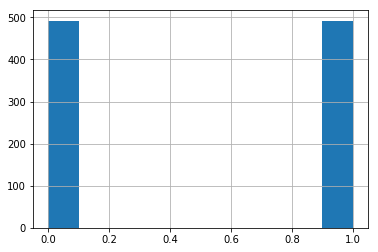

In [199]:
y_new['Class'].hist()

In [200]:
X = X_new.copy()
y = y_new.copy()

In [201]:
y = np.array(y['Class'])

## Standardize Values via Scaling

In [202]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

## Apply K-Means

In [203]:
k_means = KMeans(n_clusters=len(unique_y), random_state=123)
%timeit k_means.fit(X_std)
y_pred = k_means.predict(X_std)

134 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


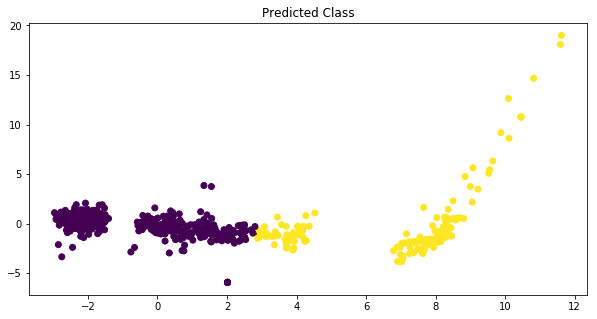

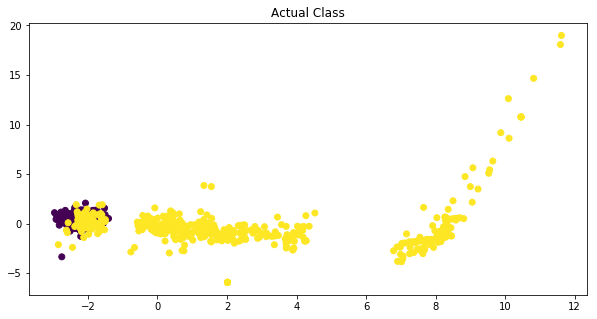

In [204]:
# Plot the solution.
X_pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.title('Predicted Class')
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.title('Actual Class')
plt.show()

In [205]:
for nclust in range(2, len(unique_y)+1):
    pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(X_std)
    print("ARI for {} cluster k-means: {}".format(nclust, metrics.adjusted_rand_score(y, pred)))
    print("Silhouette score for {} cluster k-means: {}".format(nclust, metrics.silhouette_score(X_std, pred, metric='euclidean')))

ARI for 2 cluster k-means: 0.09876393413270311
Silhouette score for 2 cluster k-means: 0.46096856632597927


## Apply Mini-Batch K-Means

In [206]:
# Defining the mini-batch k-means
minikmeans_cluster = MiniBatchKMeans(
    init='random',
    n_clusters=len(unique_y),
    batch_size=50)

# Fit model
%timeit minikmeans_cluster.fit(X_std)
minikmeans_cluster = minikmeans_cluster.predict(X_std)

58.4 ms ± 3.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


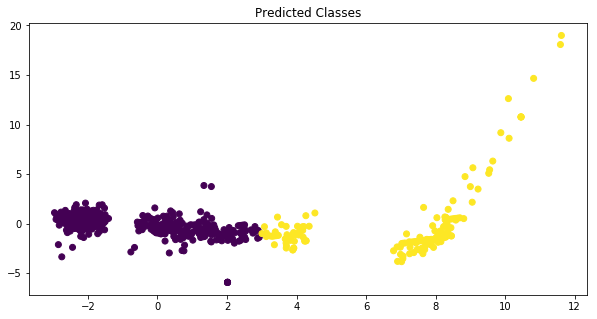

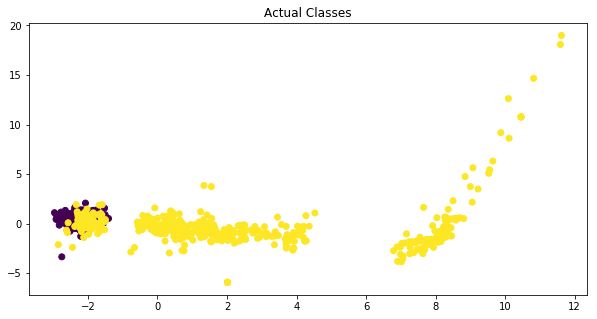

In [207]:
# Plot the solution.
plt.figure(figsize=(10,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=minikmeans_cluster)
plt.title('Predicted Classes')
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.title('Actual Classes')
plt.show()


In [208]:
for nclust in range(2, len(unique_y)+1):
    pred = minikmeans_cluster
    print("ARI for {} cluster mini k-means: {}".format(nclust, metrics.adjusted_rand_score(y, pred)))
    print("Silhouette score for {} cluster mini k-means: {}".format(nclust, metrics.silhouette_score(X_std, pred, metric='euclidean')))

ARI for 2 cluster mini k-means: 0.09496482855142428
Silhouette score for 2 cluster mini k-means: 0.46435304598028926


Both types of K-Means produce data that isn't very good. From the provided binary target feature, we know that there should only be two clusters in the dataset: fraudulent and non-fraudulent. However, the PCA shows three distinct clusters, and while the K-Means show a good separation of left and right colored points, the actual classes from the original dataset do not match up with those colors. This may be due to a sampling error with the class imbalance, or some other issue.

## Apply K-Means on Random Subsamples

In [209]:
# Split the data into two equally-sized samples. 
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(X_std, X_pca, test_size=0.5, random_state=13579)


In [210]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, len(unique_y)+1):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

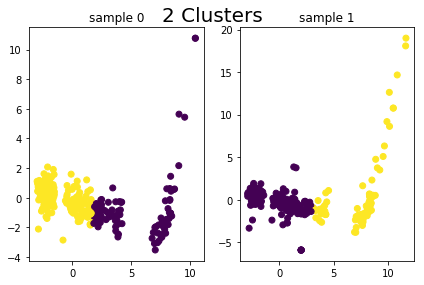

In [211]:
for cluster in range(2, len(unique_y)+1):
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)

    # Make a plot for each sample.
    for i in range(2):

        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]

        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]

        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))

    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

It seems that the K-Means form similarly colored clusters when the dataset is split into subsets, so we know that it is a relatively reliable method for our data in that different points don't cause drastically different results.

## Produce Dendograms

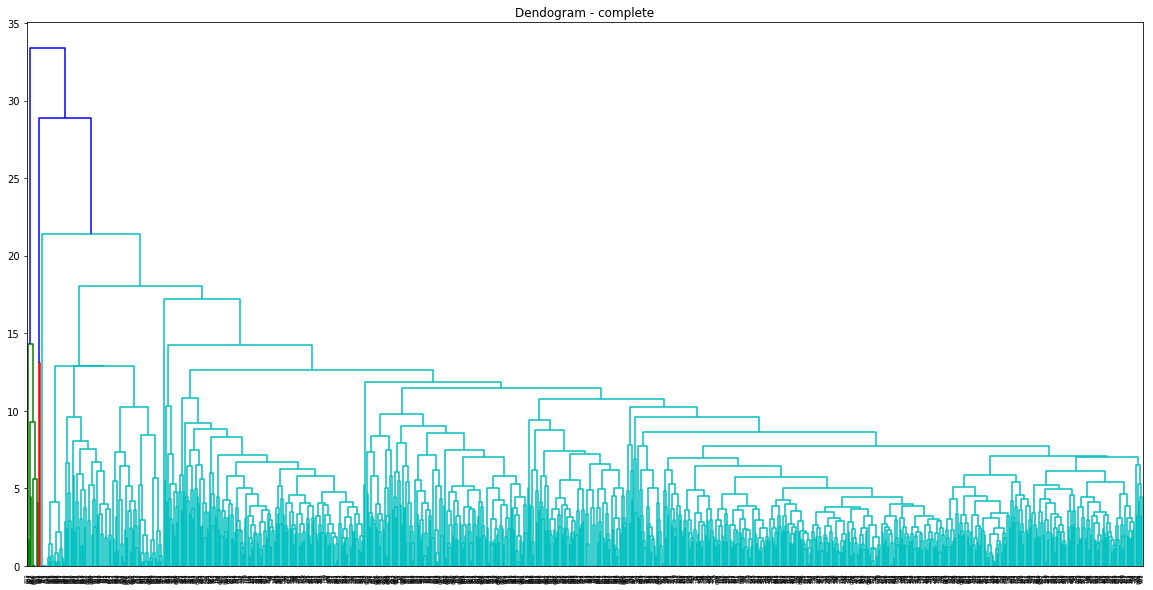

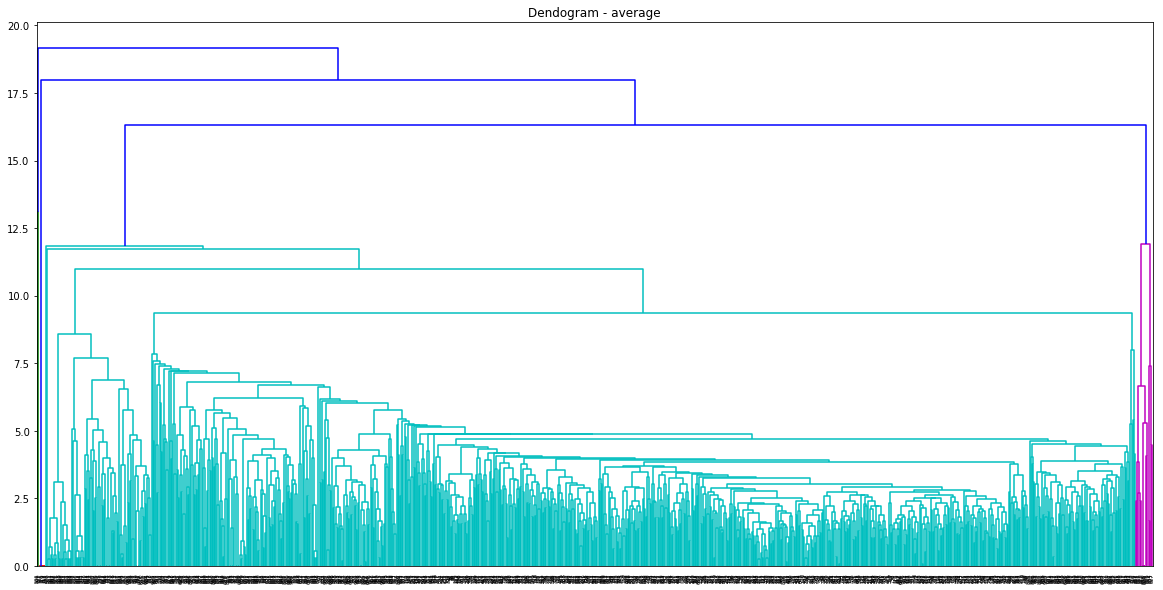

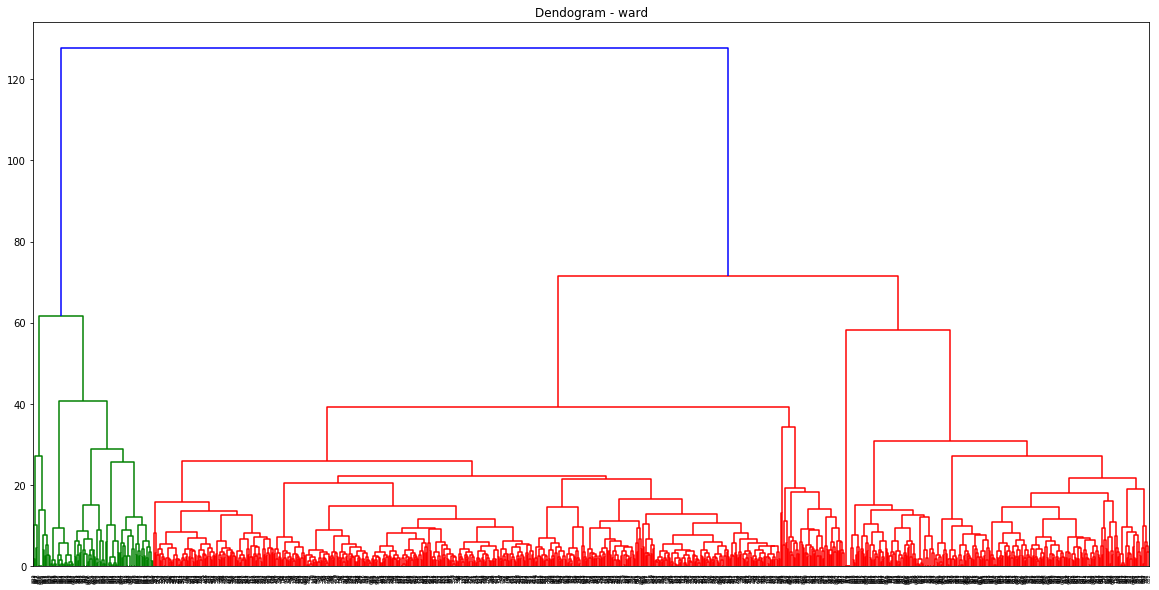

In [219]:
for link in ['complete', 'average', 'ward']:
    plt.figure(figsize=(20,10))
    dendrogram(linkage(X_std, method=link))
    plt.title('Dendogram - ' + link)
    plt.show()

From our assumption that there are two classes to which the data should be clustered, it looks like the "ward" method dendogram is the most sensible visualization. Both of the others assign too many classes or have some classes contain far too few points to be viable. 

## Agglomerative Clustering

In [220]:
affinities = ['cosine', 'cosine', 'euclidean']
linkages = ['complete', 'average', 'ward']
for i in range(len(linkages)):
    # Defining the agglomerative clustering
    agg_cluster = AgglomerativeClustering(linkage=linkages[i], 
                                          affinity=affinities[i],
                                          n_clusters=len(unique_y))

    # Fit model
    clusters = agg_cluster.fit_predict(X_std)
    
    print("Adjusted Rand Index of the Agglomerative Clustering solution, utilizing the {} method: {}"
          .format(linkages[i], metrics.adjusted_rand_score(y, clusters)))
    print("Silhoutte Score of the Agglomerative Clustering solution, utilizing the {} method: {}"
          .format(linkages[i], metrics.silhouette_score(X_std, clusters, metric=affinities[i])))
    print('\n-----------------------------------------------------------------------------------------\n')

Adjusted Rand Index of the Agglomerative Clustering solution, utilizing the complete method: 0.5805380010967774
Silhoutte Score of the Agglomerative Clustering solution, utilizing the complete method: 0.45379004079627333

-----------------------------------------------------------------------------------------

Adjusted Rand Index of the Agglomerative Clustering solution, utilizing the average method: 0.5529640344367001
Silhoutte Score of the Agglomerative Clustering solution, utilizing the average method: 0.44939479632133866

-----------------------------------------------------------------------------------------

Adjusted Rand Index of the Agglomerative Clustering solution, utilizing the ward method: 0.04604435954073096
Silhoutte Score of the Agglomerative Clustering solution, utilizing the ward method: 0.5082067036181347

-----------------------------------------------------------------------------------------



Interestingly, the "ward" method produces the highest Silhouette Score of 0.508, but the "complete" method produces the highest ARI of 0.58. Additionally, the ARI of "ward" is very low, 0.05, so it's likely that either "complete" or "average" are better methods when it comes to agglomerative clustering of this dataset.

## Gaussian Mixture Models (GMM)

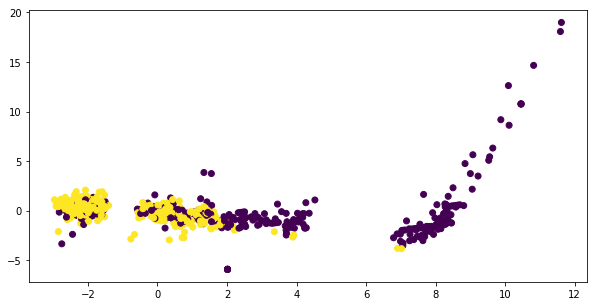

Adjusted Rand Index for GMM:  0.12134422707806236
Silhouette Score for GMM:  0.13848767210326599


In [221]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=len(unique_y), random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

# Visualize clusters
plt.figure(figsize=(10,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)
plt.show()

#Print scores
print('Adjusted Rand Index for GMM: ', metrics.adjusted_rand_score(y, clusters))
print('Silhouette Score for GMM: ', metrics.silhouette_score(X_std, clusters, metric='euclidean'))

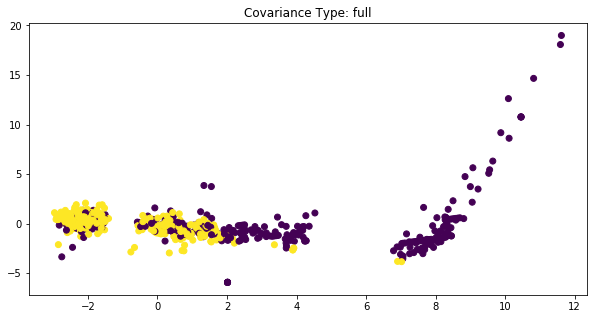

Adjusted Rand Index for GMM (Covariance Type = full): 0.12134422707806236
Silhouette Score for GMM (Covariance Type = full): 0.13848767210326599

-----------------------------------------------------------------------------------------



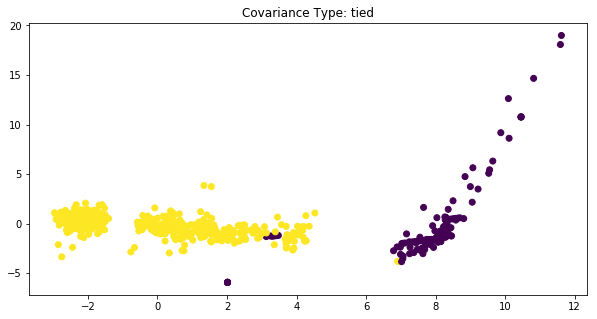

Adjusted Rand Index for GMM (Covariance Type = tied): 0.05711705324980626
Silhouette Score for GMM (Covariance Type = tied): 0.5118703041666787

-----------------------------------------------------------------------------------------



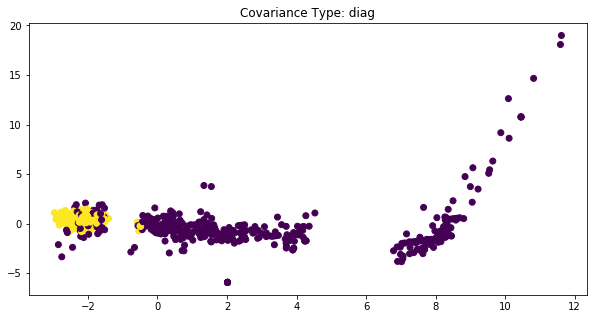

Adjusted Rand Index for GMM (Covariance Type = diag): 0.62474980917534
Silhouette Score for GMM (Covariance Type = diag): 0.24398247707128895

-----------------------------------------------------------------------------------------



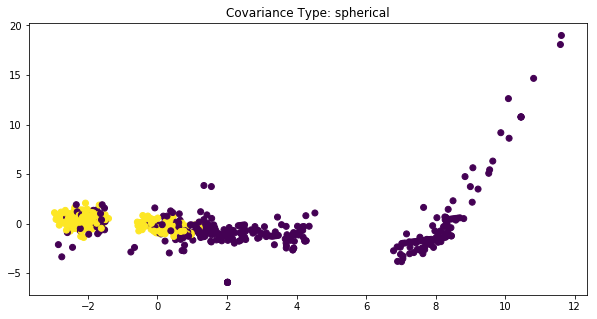

Adjusted Rand Index for GMM (Covariance Type = spherical): 0.3787016537469932
Silhouette Score for GMM (Covariance Type = spherical): 0.3242361204767715

-----------------------------------------------------------------------------------------



In [222]:
for cov in ['full', 'tied', 'diag', 'spherical']:
    # Defining the agglomerative clustering
    gmm_cluster = GaussianMixture(n_components=len(unique_y), random_state=123, covariance_type = cov)

    # Fit model
    clusters = gmm_cluster.fit_predict(X_std)

    # Visualize clusters
    plt.figure(figsize=(10,5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)
    plt.title('Covariance Type: ' + cov)
    plt.show()

    #Print scores
    print('Adjusted Rand Index for GMM (Covariance Type = {}): {}'.format(cov, metrics.adjusted_rand_score(y, clusters)))
    print('Silhouette Score for GMM (Covariance Type = {}): {}'.format(cov, metrics.silhouette_score(X_std, clusters, metric='euclidean')))
    print('\n-----------------------------------------------------------------------------------------\n')

The "tied" method shows the best visual distinction between clusters, and has the highest Silhouette Score, 0.512. However, it also has the lowest ARI, 0.057, so I'm unsure whether it's the best option for GMM Clustering. The "diag" method provides the best ARI, a value of 0.625.

## Dimensionality Reduction via t-SNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 984 samples in 0.005s...
[t-SNE] Computed neighbors for 984 samples in 0.262s...
[t-SNE] Computed conditional probabilities for sample 984 / 984
[t-SNE] Mean sigma: 1.293171
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.572792
[t-SNE] KL divergence after 300 iterations: 1.075453


<Figure size 720x360 with 0 Axes>

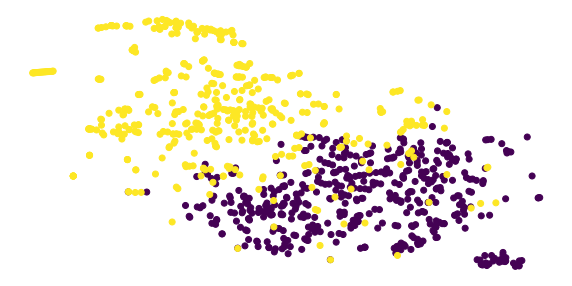

In [223]:
#Compute t-SNE components
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

#Plot results
plt.figure(figsize=(10,5))
colors = ["r","b"] #2 classes, 2 colors    #,"g","c","m","y","k","burlywood"] 
plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

Although there is some overlap of the colored points toward the center of the t-SNE plot, overall it shows good distinction of the clusters, with a relatively small amount of overlap compared to PCA.

## Dimensionality Reduction with UMAP

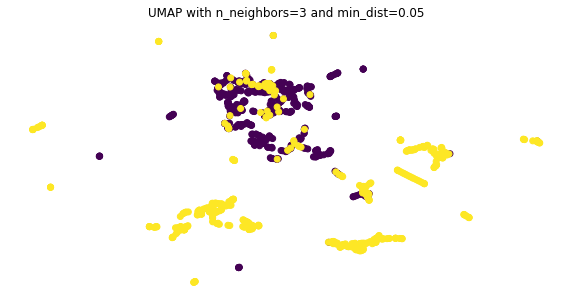

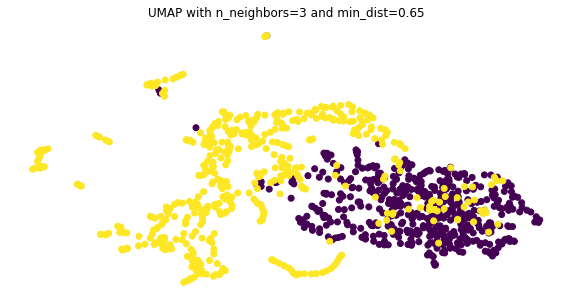

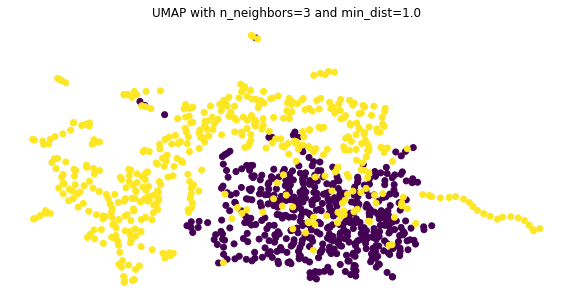

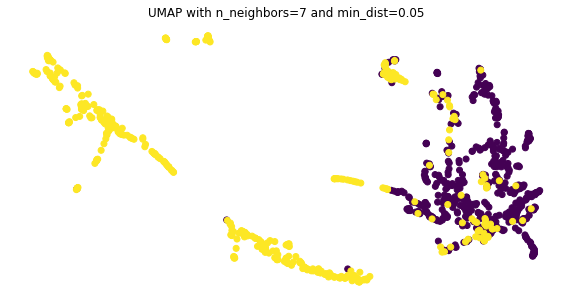

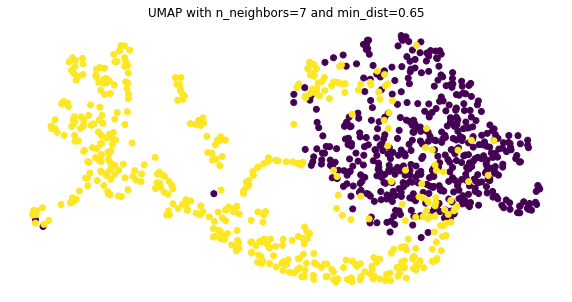

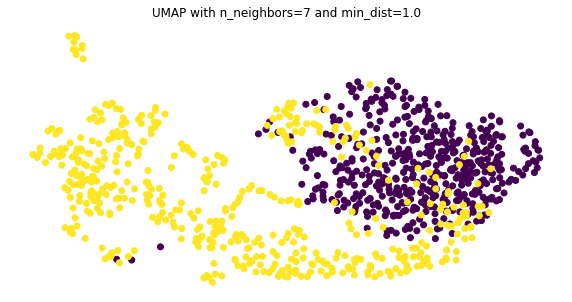

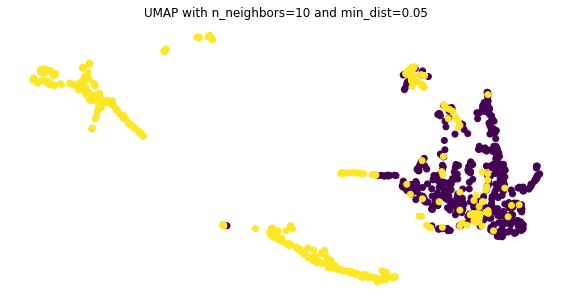

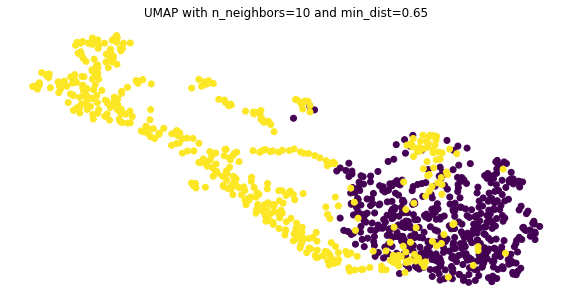

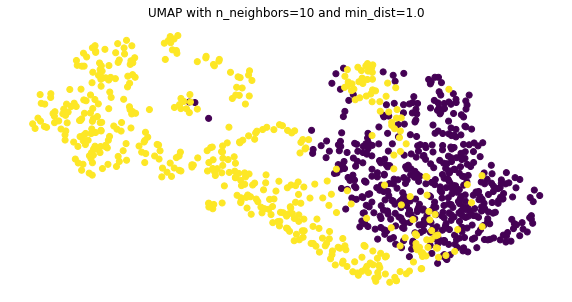

In [226]:
for neighbor in [3, 7, 10]:
    for dist in [0.05, 0.65, 1.0]:
        #Computing the UMAP components
        umap_results = umap.UMAP(n_neighbors=neighbor,
                          min_dist=dist,
                          metric='correlation').fit_transform(X)

        plt.figure(figsize=(10,5))
        plt.scatter(umap_results[:, 0], umap_results[:, 1], c=y)
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.title('UMAP with n_neighbors={} and min_dist={}'.format(neighbor, dist))
        plt.show()

The best clustering with respect to UMAP dimensionality reduction seems to be for `n_neighbors=7` and `min_dist=1.0`. It doesn't do a perfect job, as there is still some overlap, but it is definitely better than our PCA model, and possibly even a bit better than t-SNE.

## Conclusions:
Overall, the Gaussian Mixture Matrix seems to do the best job of clustering the data into appropriate groups. Of all the tests run in this challenge, GMM's "diag" method achieves the highest ARI score (0.625) and GMM's "tied" method achieves the highest Silhouette Score (0.512).